In [ ]:
import pyexasol
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establish connection to Exasol
C = pyexasol.connect(
    dsn='173.45.88.227..233:8563',
    user='app_ro',
    password='app_ro_12347',
    schema='prod_test'
)


In [52]:
pub_id = input("Enter pub_id: ").strip()
adv_domain_id = input("Enter adv_domain_id: ").strip()
tart_date = input("Enter start_date: ").strip()
end_date = input("Enter end_date: ").strip()
target = input("Enter target: ").strip()

# SQL Query
prod_df = f"""
SELECT
    a.creation_date,
    a.pub_id,
    a.adv_domain_id,
    a.channel_id,
    a.country_id,
    e.name AS publisher,
    ea.name AS adv_domain,
    SUM(seen * b.est_daily_occ_impressions) AS impressions,
    0.001 * SUM(seen * b.est_daily_occ_impressions * ad_occurrence_cpm * used_for_spend) AS spend
FROM
    (
        SELECT
            creation_date,
            channel_id,
            country_id,
            pub_id,
            adv_id,
            is_panel,
            seen,
            ad_occurrence_id,
            ad_occurrence_cpm,
            used_for_spend,
            ticket_id,
            adv_domain_id
        FROM adc2_ops.thecube
        WHERE
            mg_position = 1
            AND used_for_imprs = 1
            AND used_for_spend = 1
            AND creation_date BETWEEN '{start_date}' AND '{end_date}'
            AND country_id = 1
            AND adv_domain_id = {adv_domain_id}
            AND pub_id = {pub_id}
    ) a
JOIN adc2_dwh.pub_daily_impressions b
    ON a.creation_date = b.creation_date
    AND a.is_panel = b.is_panel
    AND a.pub_id = b.pub_id
    AND a.channel_id = b.channel_id
    AND a.country_id = b.country_id
JOIN adc2_ops.entities e ON e.id = a.pub_id
JOIN adc2_ops.entities ea ON ea.id = a.adv_domain_id
GROUP BY 1, 2, 3, 4, 5, 6, 7
"""


# Fetch data
prod_df = C.export_to_pandas(prod_df)

print(prod_df)

   CREATION_DATE   PUB_ID  ADV_DOMAIN_ID  CHANNEL_ID  COUNTRY_ID  \
0     2025-01-23  2508680       19432708           9           1   
1     2025-01-28  2508680       19432708           9           1   
2     2025-01-20  2508680       19432708          10           1   
3     2025-01-28  2508680       19432708          10           1   
4     2025-01-14  2508680       19432708           9           1   
..           ...      ...            ...         ...         ...   
57    2025-01-03  2508680       19432708          10           1   
58    2025-01-01  2508680       19432708           9           1   
59    2025-01-25  2508680       19432708           9           1   
60    2025-01-18  2508680       19432708          10           1   
61    2025-01-04  2508680       19432708          10           1   

              PUBLISHER   ADV_DOMAIN   IMPRESSIONS        SPEND  
0   http://facebook.com  shopify.com  7.071212e+05  3916.759800  
1   http://facebook.com  shopify.com  3.669156e+05 

In [53]:
# Factors table

factor_df = f"""
select 
a.*,
{target} / spend factor
from
(SELECT
    a.creation_date,
    a.channel_id,
    a.country_id,
    a.pub_id,
    a.adv_domain_id,
    a.is_panel,
    SUM(seen * b.est_daily_occ_impressions) AS impressions,
    0.001 * SUM(seen * b.est_daily_occ_impressions * ad_occurrence_cpm * used_for_spend) AS spend
FROM
    (
        SELECT
            creation_date,
            channel_id,
            country_id,
            pub_id,
            adv_id,
            is_panel,
            seen,
            ad_occurrence_id,
            ad_occurrence_cpm,
            used_for_spend,
            ticket_id,
            adv_domain_id
        FROM adc2_ops.thecube
        WHERE
            mg_position = 1
            AND used_for_imprs = 1
            AND used_for_spend = 1
            AND creation_date BETWEEN '{start_date}' AND '{end_date}'
            AND country_id = 1
            AND adv_domain_id = {adv_domain_id}
            AND pub_id = {pub_id}
    ) a
JOIN adc2_dwh.pub_daily_impressions b
    ON a.creation_date = b.creation_date
    AND a.is_panel = b.is_panel
    AND a.pub_id = b.pub_id
    AND a.channel_id = b.channel_id
    AND a.country_id = b.country_id
JOIN adc2_ops.entities e ON e.id = a.pub_id
JOIN adc2_ops.entities ea ON ea.id = a.adv_domain_id
GROUP BY 1, 2, 3, 4, 5, 6) a
"""


# Fetch data
factor_df = C.export_to_pandas(factor_df)

print(factor_df)

    CREATION_DATE  CHANNEL_ID  COUNTRY_ID   PUB_ID  ADV_DOMAIN_ID  IS_PANEL  \
0      2025-01-06           9           1  2508680       19432708         1   
1      2025-01-02           9           1  2508680       19432708         0   
2      2025-01-05           9           1  2508680       19432708         1   
3      2025-01-03           9           1  2508680       19432708         1   
4      2025-01-07           9           1  2508680       19432708         0   
..            ...         ...         ...      ...            ...       ...   
112    2025-01-02           9           1  2508680       19432708         1   
113    2025-01-05           9           1  2508680       19432708         0   
114    2025-01-01           9           1  2508680       19432708         1   
115    2025-01-04           9           1  2508680       19432708         1   
116    2025-01-07           9           1  2508680       19432708         1   

      IMPRESSIONS        SPEND    FACTOR  
0    2.4

In [ ]:
# The cube simulation table

tc_simulation = f"""
SELECT
            creation_date,
            channel_id,
            country_id,
            pub_id,
            adv_id,
            is_panel,
            seen * 100 seen,
            ad_occurrence_id,
            ad_occurrence_cpm,
            used_for_spend,
            ticket_id,
            adv_domain_id
        FROM adc2_ops.thecube
        WHERE
            mg_position = 1
            AND used_for_imprs = 1
            AND used_for_spend = 1
            AND creation_date BETWEEN '{start_date}' AND '{end_date}'
            AND country_id = 1
            AND pub_id = {pub_id}
"""
# Fetch data
tc_df = C.export_to_pandas(tc_simulation)


print(tc_df)


In [55]:
# Impressions simulation table

imp_simulation = f"""
SELECT
            CREATION_DATE,
            CHANNEL_ID,
            COUNTRY_ID,
            PUB_ID,
            IS_PANEL,
            TOTAL_DAILY_OCCS * 100 TOTAL_DAILY_OCCS,
            EST_DAILY_OCC_IMPRESSIONS / 100 EST_DAILY_OCC_IMPRESSIONS
        FROM adc2_dwh.pub_daily_impressions
        WHERE
            creation_date BETWEEN '{start_date}' AND '{end_date}'
            AND country_id = 1
            AND pub_id = {pub_id}
"""

# Fetch data
imp_df = C.export_to_pandas(imp_simulation)

print(imp_df)

    CREATION_DATE  CHANNEL_ID  COUNTRY_ID   PUB_ID  IS_PANEL  \
0      2025-01-06           9           1  2508680         1   
1      2025-01-07           9           1  2508680         1   
2      2025-01-10           9           1  2508680         1   
3      2025-01-11           9           1  2508680         1   
4      2025-01-21           9           1  2508680         1   
..            ...         ...         ...      ...       ...   
119    2025-01-20          10           1  2508680         1   
120    2025-01-22          10           1  2508680         1   
121    2025-01-24          10           1  2508680         1   
122    2025-01-25          10           1  2508680         1   
123    2025-01-27          10           1  2508680         1   

     TOTAL_DAILY_OCCS  EST_DAILY_OCC_IMPRESSIONS  
0      13635515327300                   0.000276  
1       9662367132600                   0.000399  
2      12162848431500                   0.000321  
3       7815561882300      

In [56]:
# Merge The cube simulation table with factors table

tc_df.columns = tc_df.columns.str.lower()
factor_df.columns = factor_df.columns.str.lower()

# Merge
tc_factored_df = pd.merge(
    tc_df,
    factor_df,
    how='inner',
    on=['creation_date', 'channel_id', 'country_id', 'pub_id','adv_domain_id', 'is_panel']
)

# Multiply seen by 5
tc_factored_df['seen'] = tc_factored_df['seen'] * tc_factored_df['factor'] 

# Optional: View result
print(tc_factored_df.head())

  creation_date  channel_id  country_id   pub_id   adv_id  is_panel  \
0    2025-01-02          10           1  2508680  1023173         0   
1    2025-01-02          10           1  2508680  1023173         0   
2    2025-01-02          10           1  2508680  1023173         0   
3    2025-01-02          10           1  2508680  1023173         0   
4    2025-01-02          10           1  2508680  1023173         0   

           seen                      ad_occurrence_id  ad_occurrence_cpm  \
0  2.835434e+06  f5eaac70-a276-4d9c-abaf-876ce29f858e            9.00804   
1  2.835434e+06  55a22381-9c86-447e-a1c5-acd3096e85ab            8.82707   
2  2.835434e+06  60362c40-ca8e-4419-8d43-1286682ad654            8.86142   
3  2.835434e+06  cd17187d-8c87-4c73-803e-1221d967e418            8.95778   
4  2.835434e+06  c95da0b0-6c8d-4dab-81ba-44ff2a2b64e0            8.98605   

   used_for_spend                             ticket_id  adv_domain_id  \
0               1  de25f669-4670-4cfe-bfb1

In [57]:
# Simulation_df
imp_simulation = C.export_to_pandas(imp_simulation)
imp_simulation.columns = imp_simulation.columns.str.lower()
#Step 1: Standardize column names
tc_factored_df.columns = tc_factored_df.columns.str.lower()
imp_simulation.columns = imp_simulation.columns.str.lower()


In [58]:
#Step 2: Merge 
merged_df = pd.merge(
    tc_factored_df,
    imp_simulation,
    on=['creation_date', 'channel_id', 'country_id', 'pub_id', 'is_panel'],
    how='inner'
)

#Step 3: Calculate impressions and spend
merged_df['impressions'] = merged_df['seen'] * merged_df['est_daily_occ_impressions']
merged_df['spend'] = 0.001 * merged_df['impressions'] * merged_df['ad_occurrence_cpm'] * merged_df['used_for_spend']


#Step 4: Group and aggregate

grouped_df = merged_df.groupby(['creation_date', 'pub_id', 'adv_domain_id'], as_index=False).agg({
    'impressions': 'sum',
    'spend': 'sum'
})

print(grouped_df.head())

  creation_date   pub_id  adv_domain_id   impressions  spend
0    2025-01-01  2508680       19432708  29109.788745  200.0
1    2025-01-02  2508680       19432708  57366.885314  400.0
2    2025-01-03  2508680       19432708  29183.020165  200.0
3    2025-01-04  2508680       19432708  29178.747384  200.0
4    2025-01-05  2508680       19432708  58268.746611  400.0


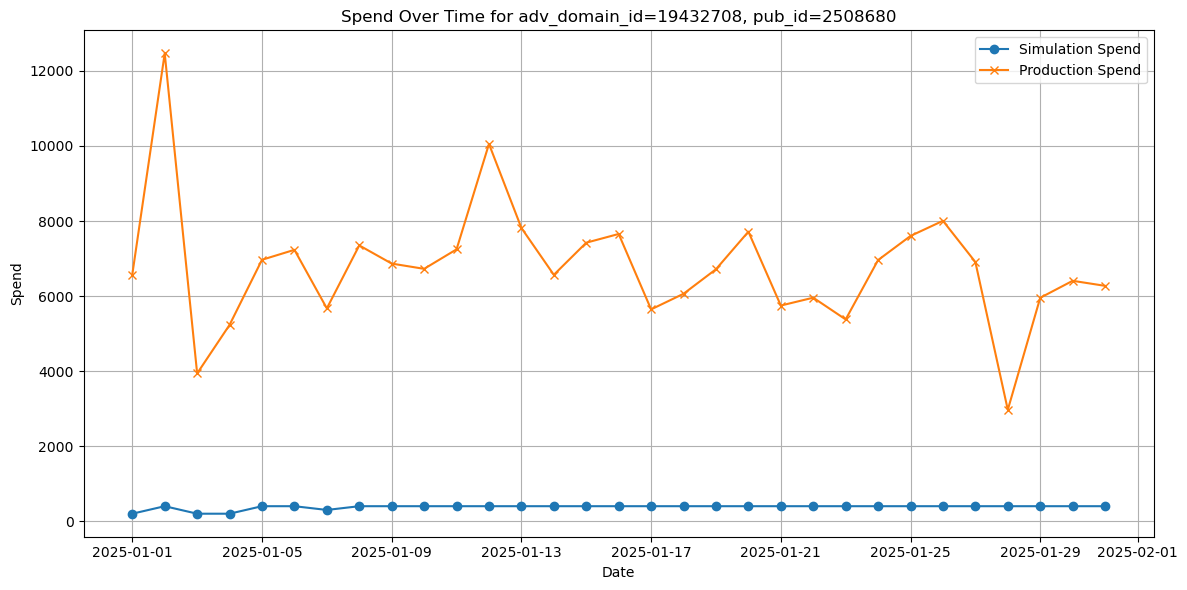

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Standardize column names
grouped_df.columns = grouped_df.columns.str.lower()
prod_df.columns = prod_df.columns.str.lower()

# Ensure creation_date is datetime
grouped_df['creation_date'] = pd.to_datetime(grouped_df['creation_date'])
prod_df['creation_date'] = pd.to_datetime(prod_df['creation_date'])

# Group and sum spend
grouped_agg = grouped_df.groupby(['creation_date', 'adv_domain_id', 'pub_id'])['spend'].sum().reset_index()
prod_agg = prod_df.groupby(['creation_date', 'adv_domain_id', 'pub_id'])['spend'].sum().reset_index()

# (Optional) Filter for one advertiser/publisher if too many lines:
# For example, pick one adv_domain_id and pub_id for visualization:
adv_id_to_plot = grouped_agg['adv_domain_id'].iloc[0]
pub_id_to_plot = grouped_agg['pub_id'].iloc[0]

grouped_filtered = grouped_agg[
    (grouped_agg['adv_domain_id'] == adv_id_to_plot) & 
    (grouped_agg['pub_id'] == pub_id_to_plot)
]

prod_filtered = prod_agg[
    (prod_agg['adv_domain_id'] == adv_id_to_plot) & 
    (prod_agg['pub_id'] == pub_id_to_plot)
]

# Sort for plotting
grouped_filtered = grouped_filtered.sort_values('creation_date')
prod_filtered = prod_filtered.sort_values('creation_date')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(grouped_filtered['creation_date'], grouped_filtered['spend'], label='Simulation Spend', marker='o')
plt.plot(prod_filtered['creation_date'], prod_filtered['spend'], label='Production Spend', marker='x')

plt.title(f"Spend Over Time for adv_domain_id={adv_id_to_plot}, pub_id={pub_id_to_plot}")
plt.xlabel('Date')
plt.ylabel('Spend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()